In [ ]:
pip install mord

  Created wheel for mord: filename=mord-0.6-cp36-none-any.whl size=6008 sha256=c4d6d492b3a54335150314e1963e50cdf443cfa4edf38f5ba3a52f600e4756d1
  Stored in directory: /root/.cache/pip/wheels/98/14/b2/244c2cec93a0c6edb29b488bd6b2710ded7e9d457033b86366
Successfully built mord


In [ ]:
pip install dmba

In [2]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score

In [3]:
oak_df=pd.read_csv(r'C:\Users\Glori\Desktop\HW\Capstone/Client ID Data 12 Oaks all websites.csv')
oak_df.columns = [c.replace(' ', '_') for c in oak_df.columns]
oak_df = oak_df.rename(columns={"Avg._Session_Duration" : "Average_duration" })
oak_df.head()

,Client_Id,Sessions,Average_duration,Bounce_Rate,Goal_Conversion_Rate,New_User,Returning_Users,Direct,Organic,Search,Paid,Referral,Mobile_Tablet,Mobile,Tablet,Tablet_Desktop,US
0,1666687355,279,8.75,21.15%,4.30%,0,1,0,0,1,1,1,0,0,0,1,1
1,2004874326,246,0.63,69.92%,0.00%,1,1,0,0,0,0,1,0,0,0,1,1
2,855656721.2,111,3.83,29.73%,1.80%,0,1,1,1,1,1,1,0,0,0,1,1
3,2144189866,97,3.95,25.77%,0.00%,1,1,0,0,0,0,1,0,0,0,1,1
4,1022022740,78,10.45,10.26%,0.00%,0,1,1,0,0,0,0,0,0,0,1,1


In [4]:
oak_df.Bounce_Rate = oak_df.Bounce_Rate.str.strip('%').astype(float) / 100
oak_df.Goal_Conversion_Rate = oak_df.Goal_Conversion_Rate.str.strip('%').astype(float) / 100

In [5]:
oak_df.describe()

,Sessions,Average_duration,Bounce_Rate,Goal_Conversion_Rate,New_User,Returning_Users,Direct,Organic,Search,Paid,Referral,Mobile_Tablet,Mobile,Tablet,Tablet_Desktop,US
count,23489.000000,23489.000000,23489.000000,23489.000000,23489.000000,23489.000000,23489.000000,23489.000000,23489.000000,23489.000000,23489.000000,23489.000000,23489.000000,23489.000000,23489.000000,23489.000000
mean,1.286134,1.188900,0.492977,0.015421,0.425731,0.140662,0.222615,0.323726,0.425731,0.247392,0.049896,0.425731,0.425731,0.059773,0.425731,0.425731
std,2.835417,3.831446,0.485639,0.117767,0.494464,0.347680,0.416011,0.467907,0.494464,0.431506,0.217734,0.494464,0.494464,0.237070,0.494464,0.494464
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.020000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.600000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,279.000000,127.800000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
ana_df = oak_df.copy()
ana_df['Long_duration'] = [1 if value >= 2 else 0 for value in ana_df['Average_duration']]
ana_df['Low_Bounce_Rate'] = [1 if value <= 0.6 else 0 for value in ana_df['Bounce_Rate']]
ana_df['High_Sessions'] = [1 if value >= 20 else 0 for value in ana_df['Sessions']]
ana_df['Goal']= [0 if value == 0 else 1 for value in ana_df['Goal_Conversion_Rate']]
ana_df = ana_df.drop(columns=['Sessions','Average_duration','Bounce_Rate','Goal_Conversion_Rate'])
ana_df.head(5)

,Client_Id,New_User,Returning_Users,Direct,Organic,Search,Paid,Referral,Mobile_Tablet,Mobile,Tablet,Tablet_Desktop,US,Long_duration,Low_Bounce_Rate,High_Sessions,Goal
0,1666687355,0,1,0,0,1,1,1,0,0,0,1,1,1,1,1,1
1,2004874326,1,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0
2,855656721.2,0,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1
3,2144189866,1,1,0,0,0,0,1,0,0,0,1,1,1,1,1,0
4,1022022740,0,1,1,0,0,0,0,0,0,0,1,1,1,1,1,0


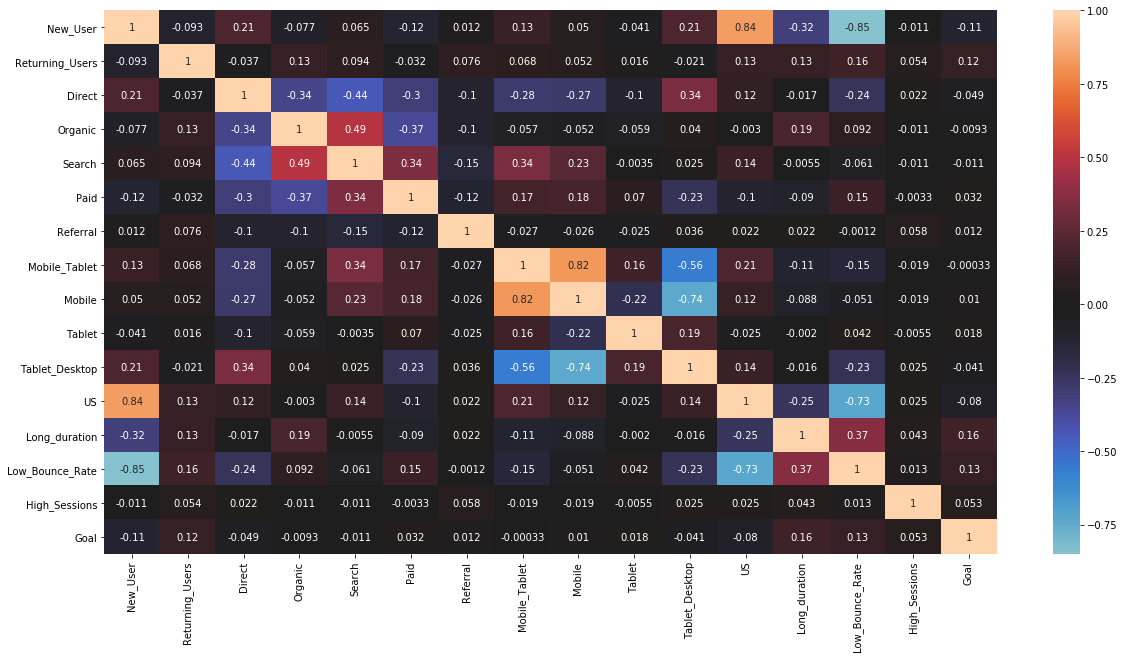

In [7]:
corr = ana_df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corr, annot=True, center=0,ax=ax)

In [8]:
# Aviod multicollinearity
ana_df = ana_df.drop(columns=['US','New_User','Tablet_Desktop','Mobile_Tablet'])
ana_df.head(5)

,Client_Id,Returning_Users,Direct,Organic,Search,Paid,Referral,Mobile,Tablet,Long_duration,Low_Bounce_Rate,High_Sessions,Goal
0,1666687355,1,0,0,1,1,1,0,0,1,1,1,1
1,2004874326,1,0,0,0,0,1,0,0,0,0,1,0
2,855656721.2,1,1,1,1,1,1,0,0,1,1,1,1
3,2144189866,1,0,0,0,0,1,0,0,1,1,1,0
4,1022022740,1,1,0,0,0,0,0,0,1,1,1,0


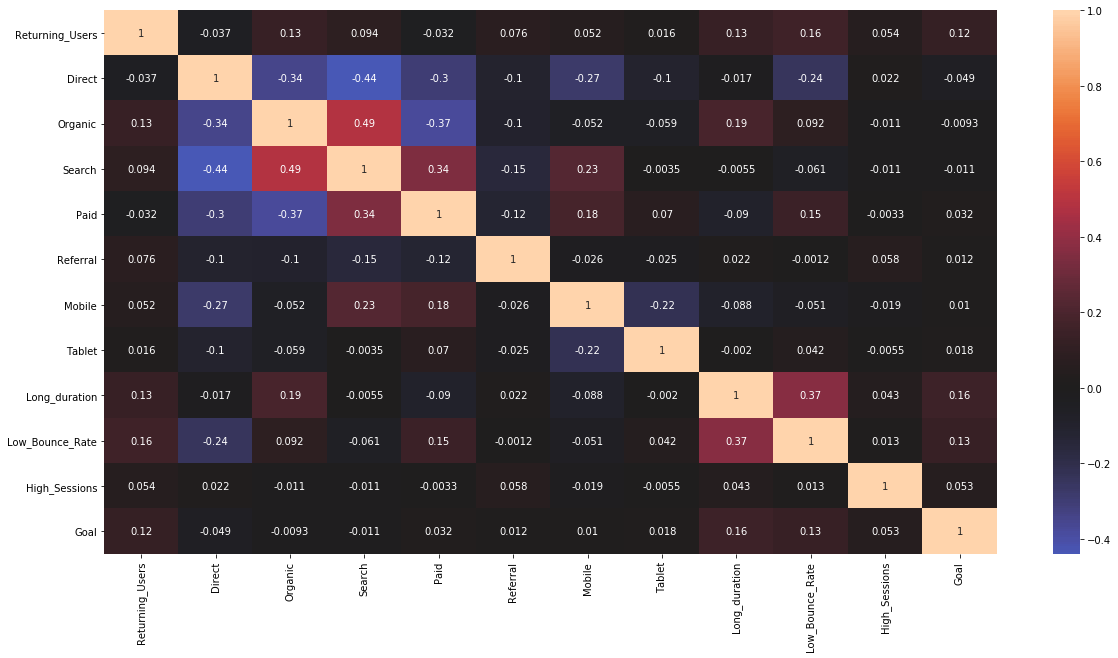

In [9]:
# Double Check
corr = ana_df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.heatmap(corr, annot=True, center=0,ax=ax)

In [10]:
class_df = ana_df.copy()

Logistic regression - full predictors

In [11]:
# full predictors
y = class_df['Goal']
X = class_df.drop(columns=['Client_Id','Goal'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegressionCV(penalty="l2", solver='liblinear', cv=3)
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns))
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -0.4215505322667828
                    coeff
Returning_Users -0.045216
Direct          -0.106206
Organic         -0.127545
Search          -0.162346
Paid            -0.094167
Referral        -0.022427
Mobile          -0.165155
Tablet          -0.025339
Long_duration   -0.043422
Low_Bounce_Rate -0.196627
High_Sessions   -0.000132

AIC -9623.30254173329


In [12]:
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9811)

       Prediction
Actual     0     1
     0 13826     0
     1   267     0
Confusion Matrix (Accuracy 0.9790)

       Prediction
Actual    0    1
     0 9199    0
     1  197    0


Oversampling for Logistic regression

In [13]:
# oversampling
weights = [0.9 if g == 1 else 0.01 for g in ana_df.Goal]
over_df = class_df.sample(1000, weights=weights,random_state=1)
over_df['Goal'].value_counts()

0    580
1    420
Name: Goal, dtype: int64

In [14]:
over_df.head(10)

,Client_Id,Returning_Users,Direct,Organic,Search,Paid,Referral,Mobile,Tablet,Long_duration,Low_Bounce_Rate,High_Sessions,Goal
5918,125353144.2,0,0,0,1,1,0,0,0,1,1,0,1
14782,2086865992,0,0,0,0,1,0,1,0,1,1,0,1
0,1666687355,1,0,0,1,1,1,0,0,1,1,1,1
2896,648774006.2,1,1,0,1,1,0,1,0,0,1,0,1
999,64062131.16,1,0,0,0,1,0,0,0,0,1,0,1
555,1159491539,1,0,1,1,1,0,0,0,0,1,0,1
1386,1251776276,1,0,0,1,1,0,1,0,1,1,0,0
3608,1030946579,0,0,0,1,1,0,1,0,0,1,0,0
5234,1183100375,0,0,0,1,1,0,1,0,0,1,0,0
9555,1595064187,0,0,0,0,0,0,1,0,0,1,0,1


In [15]:
y2 = over_df['Goal']
X2 = over_df.drop(columns=['Client_Id','Goal'])

# partition data
train_X2, valid_X2, train_y2, valid_y2 = train_test_split(X2, y2, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg2 = LogisticRegressionCV(penalty="l2", solver='liblinear', cv=3)
logit_reg2.fit(train_X2, train_y2)

print('intercept ', logit_reg2.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg2.coef_[0]}, index=X2.columns).transpose())
print()
print('AIC', AIC_score(valid_y2, logit_reg2.predict(valid_X2), df = len(train_X2.columns) + 1))

intercept  -1.8039675654074434
       Returning_Users    Direct   Organic    Search      Paid  Referral  \
coeff          1.62394 -1.190453 -1.139062 -0.163307 -0.112627 -0.235904   

         Mobile    Tablet  Long_duration  Low_Bounce_Rate  High_Sessions  
coeff -0.339952  0.198688       1.428655          1.88155       0.225488  

AIC 568.9088103272853


In [16]:
classificationSummary(train_y2, logit_reg2.predict(train_X2))
classificationSummary(valid_y2, logit_reg2.predict(valid_X2))

Confusion Matrix (Accuracy 0.7983)

       Prediction
Actual   0   1
     0 268  66
     1  55 211
Confusion Matrix (Accuracy 0.7725)

       Prediction
Actual   0   1
     0 197  49
     1  42 112


In [17]:
#Check accuracy rate with original validation dataset
classificationSummary(valid_y, logit_reg2.predict(valid_X))

Confusion Matrix (Accuracy 0.7795)

       Prediction
Actual    0    1
     0 7173 2026
     1   46  151


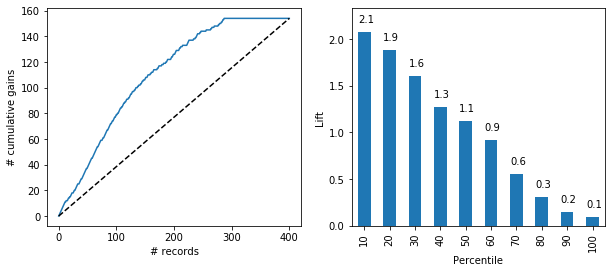

In [18]:
# Oversampled validation dataset
logit_reg_pred2 = logit_reg2.predict(valid_X2)
logit_reg_proba2 = logit_reg2.predict_proba(valid_X2)

logit_result2 = pd.DataFrame({'actual': valid_y2,
  'p(0)': [p[0] for p in logit_reg_proba2],
  'p(1)': [p[1] for p in logit_reg_proba2],
  'predicted': logit_reg_pred2 })
df2 = logit_result2.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df2.actual, ax=axes[0])
liftChart(df2['p(1)'], title=False, ax=axes[1])
plt.show()

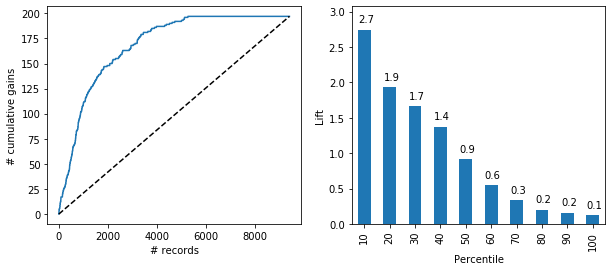

In [19]:
# Original validation dataset
logit_reg_pred2 = logit_reg2.predict(valid_X)
logit_reg_proba2 = logit_reg2.predict_proba(valid_X)

logit_result2 = pd.DataFrame({'actual': valid_y,
  'p(0)': [p[0] for p in logit_reg_proba2],
  'p(1)': [p[1] for p in logit_reg_proba2],
  'predicted': logit_reg_pred2 })
df3 = logit_result2.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df3.actual, ax=axes[0])
liftChart(df3['p(1)'], title=False, ax=axes[1])
plt.show()

In [20]:
df3.head(10)

,actual,p(0),p(1),predicted
2343,0,0.034594,0.965406,1
2270,0,0.034594,0.965406,1
1035,1,0.041879,0.958121,1
2748,1,0.041879,0.958121,1
1026,1,0.041879,0.958121,1
1596,0,0.041879,0.958121,1
1314,1,0.041879,0.958121,1
2958,0,0.041879,0.958121,1
2735,0,0.041879,0.958121,1
1181,0,0.041879,0.958121,1


# ***Classification Tree***

In [21]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary

In [22]:
tree_df = oak_df.copy()
tree_df['Goal']= [0 if value == 0 else 1 for value in tree_df['Goal_Conversion_Rate']]
tree_df = tree_df.drop(columns=['Goal_Conversion_Rate'])
tree_df.shape

(23489, 17)

In [23]:
X_Tree = tree_df.drop(columns=['Goal','Client_Id'])
y_Tree = tree_df['Goal']
train_X_Tree, valid_X_Tree, train_y_Tree, valid_y_Tree = train_test_split(X_Tree, y_Tree, test_size=0.4, random_state=1)

fullClassTree = DecisionTreeClassifier()
fullClassTree.fit(train_X_Tree, train_y_Tree)
plotDecisionTree(fullClassTree, feature_names=train_X_Tree.columns,max_depth=2,rotate=True)

'You need to install pydotplus to visualize decision trees'

In [24]:
classificationSummary(train_y_Tree, fullClassTree.predict(train_X_Tree))
classificationSummary(valid_y_Tree, fullClassTree.predict(valid_X_Tree))

Confusion Matrix (Accuracy 0.9971)

       Prediction
Actual     0     1
     0 13826     0
     1    41   226
Confusion Matrix (Accuracy 0.9666)

       Prediction
Actual    0    1
     0 9056  143
     1  171   26


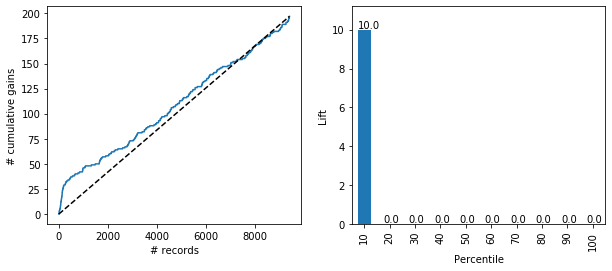

In [25]:
tree_pred = fullClassTree.predict(valid_X_Tree)
tree_proba = fullClassTree.predict_proba(valid_X_Tree)
tree_result = pd.DataFrame({'actual': valid_y_Tree,
  'p(0)': [p[0] for p in tree_proba],
  'p(1)': [p[1] for p in tree_proba],
  'predicted': tree_pred })
df = tree_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.show()

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
param_grid = {
    'max_depth': [10, 20, 30, 40], 
    'min_samples_split': [20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X_Tree, train_y_Tree)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)


Improved score:  0.9810544437509741
Improved parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.0005, 'min_samples_split': 20}


In [27]:
# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(4, 16)), 
    'min_samples_split': list(range(10, 22)), 
    'min_impurity_decrease': [0.0004, 0.0005, 0.0006], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X_Tree, train_y_Tree)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

bestClassTree = gridSearch.best_estimator_

Improved score:  0.9810544437509741
Improved parameters:  {'max_depth': 4, 'min_impurity_decrease': 0.0004, 'min_samples_split': 10}


In [28]:
bestClassTree

DecisionTreeClassifier(max_depth=4, min_impurity_decrease=0.0004,
                       min_samples_split=10)

In [29]:
plotDecisionTree(bestClassTree, feature_names=train_X_Tree.columns)

'You need to install pydotplus to visualize decision trees'

In [30]:
classificationSummary(train_y_Tree, bestClassTree.predict(train_X_Tree))
classificationSummary(valid_y_Tree, bestClassTree.predict(valid_X_Tree))

Confusion Matrix (Accuracy 0.9811)

       Prediction
Actual     0     1
     0 13826     0
     1   267     0
Confusion Matrix (Accuracy 0.9790)

       Prediction
Actual    0    1
     0 9199    0
     1  197    0


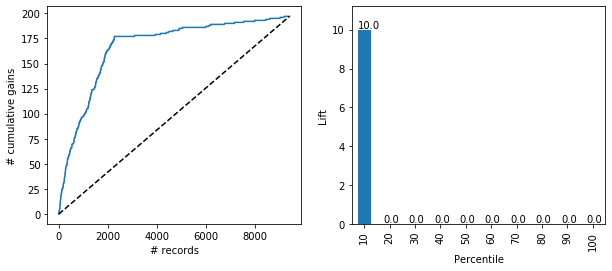

In [31]:
tree_pred2 = bestClassTree.predict(valid_X_Tree)
tree_proba2 = bestClassTree.predict_proba(valid_X_Tree)
tree_result2 = pd.DataFrame({'actual': valid_y_Tree,
  'p(0)': [p[0] for p in tree_proba2],
  'p(1)': [p[1] for p in tree_proba2],
  'predicted': tree_pred2 })
df2 = tree_result2.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df2.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.show()

In [32]:
# oversample goal conversion rate
weights = [0.9 if g == 1 else 0.01 for g in tree_df.Goal]
over_tree_df = tree_df.sample(1000, weights=weights,random_state=1)
over_tree_df['Goal'].value_counts()

0    580
1    420
Name: Goal, dtype: int64

In [33]:
X_Tree2 = over_tree_df.drop(columns=['Goal','Client_Id'])
y_Tree2 = over_tree_df['Goal']
train_X_Tree2, valid_X_Tree2, train_y_Tree2, valid_y_Tree2 = train_test_split(X_Tree2, y_Tree2, test_size=0.4, random_state=1)

fullClassTree2 = DecisionTreeClassifier()
fullClassTree2.fit(train_X_Tree2, train_y_Tree2)
plotDecisionTree(fullClassTree2, feature_names=train_X_Tree2.columns,max_depth=2,rotate=True)

'You need to install pydotplus to visualize decision trees'

In [34]:
classificationSummary(train_y_Tree2, fullClassTree2.predict(train_X_Tree2))
classificationSummary(valid_y_Tree2, fullClassTree2.predict(valid_X_Tree2))

Confusion Matrix (Accuracy 0.9983)

       Prediction
Actual   0   1
     0 334   0
     1   1 265
Confusion Matrix (Accuracy 0.7850)

       Prediction
Actual   0   1
     0 208  38
     1  48 106


In [35]:

param_grid = {
    'max_depth': [10, 20, 30, 40], 
    'min_samples_split': [20, 40, 60, 80, 100], 
    'min_impurity_decrease': [0, 0.0005, 0.001, 0.005, 0.01], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X_Tree2, train_y_Tree2)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)


Improved score:  0.8616666666666667
Improved parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.005, 'min_samples_split': 20}


In [36]:
# Adapt grid based on result from initial grid search
param_grid = {
    'max_depth': list(range(4, 16)), 
    'min_samples_split': list(range(10, 22)), 
    'min_impurity_decrease': [0.0004, 0.0005, 0.0006], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X_Tree2, train_y_Tree2)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

bestClassTree2 = gridSearch.best_estimator_

Improved score:  0.8683333333333334
Improved parameters:  {'max_depth': 5, 'min_impurity_decrease': 0.0004, 'min_samples_split': 10}


In [37]:
classificationSummary(train_y_Tree2, bestClassTree2.predict(train_X_Tree2))
classificationSummary(valid_y_Tree2, bestClassTree2.predict(valid_X_Tree2))

Confusion Matrix (Accuracy 0.9033)

       Prediction
Actual   0   1
     0 299  35
     1  23 243
Confusion Matrix (Accuracy 0.8350)

       Prediction
Actual   0   1
     0 212  34
     1  32 122


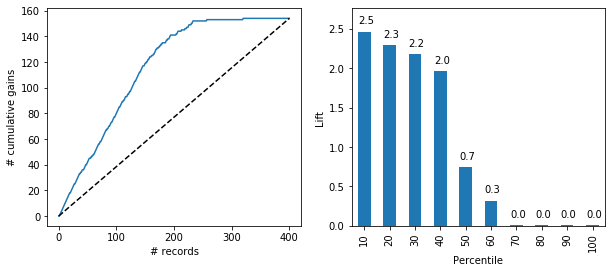

In [60]:
over_tree_pred = bestClassTree2.predict(valid_X_Tree2)
over_tree_proba = bestClassTree2.predict_proba(valid_X_Tree2)
over_tree_result = pd.DataFrame({'actual': valid_y_Tree2,
  'p(0)': [p[0] for p in over_tree_proba],
  'p(1)': [p[1] for p in over_tree_proba],
  'predicted': over_tree_pred })
dfo = over_tree_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(dfo .actual, ax=axes[0])
liftChart(dfo ['p(1)'], title=False, ax=axes[1])
plt.show()

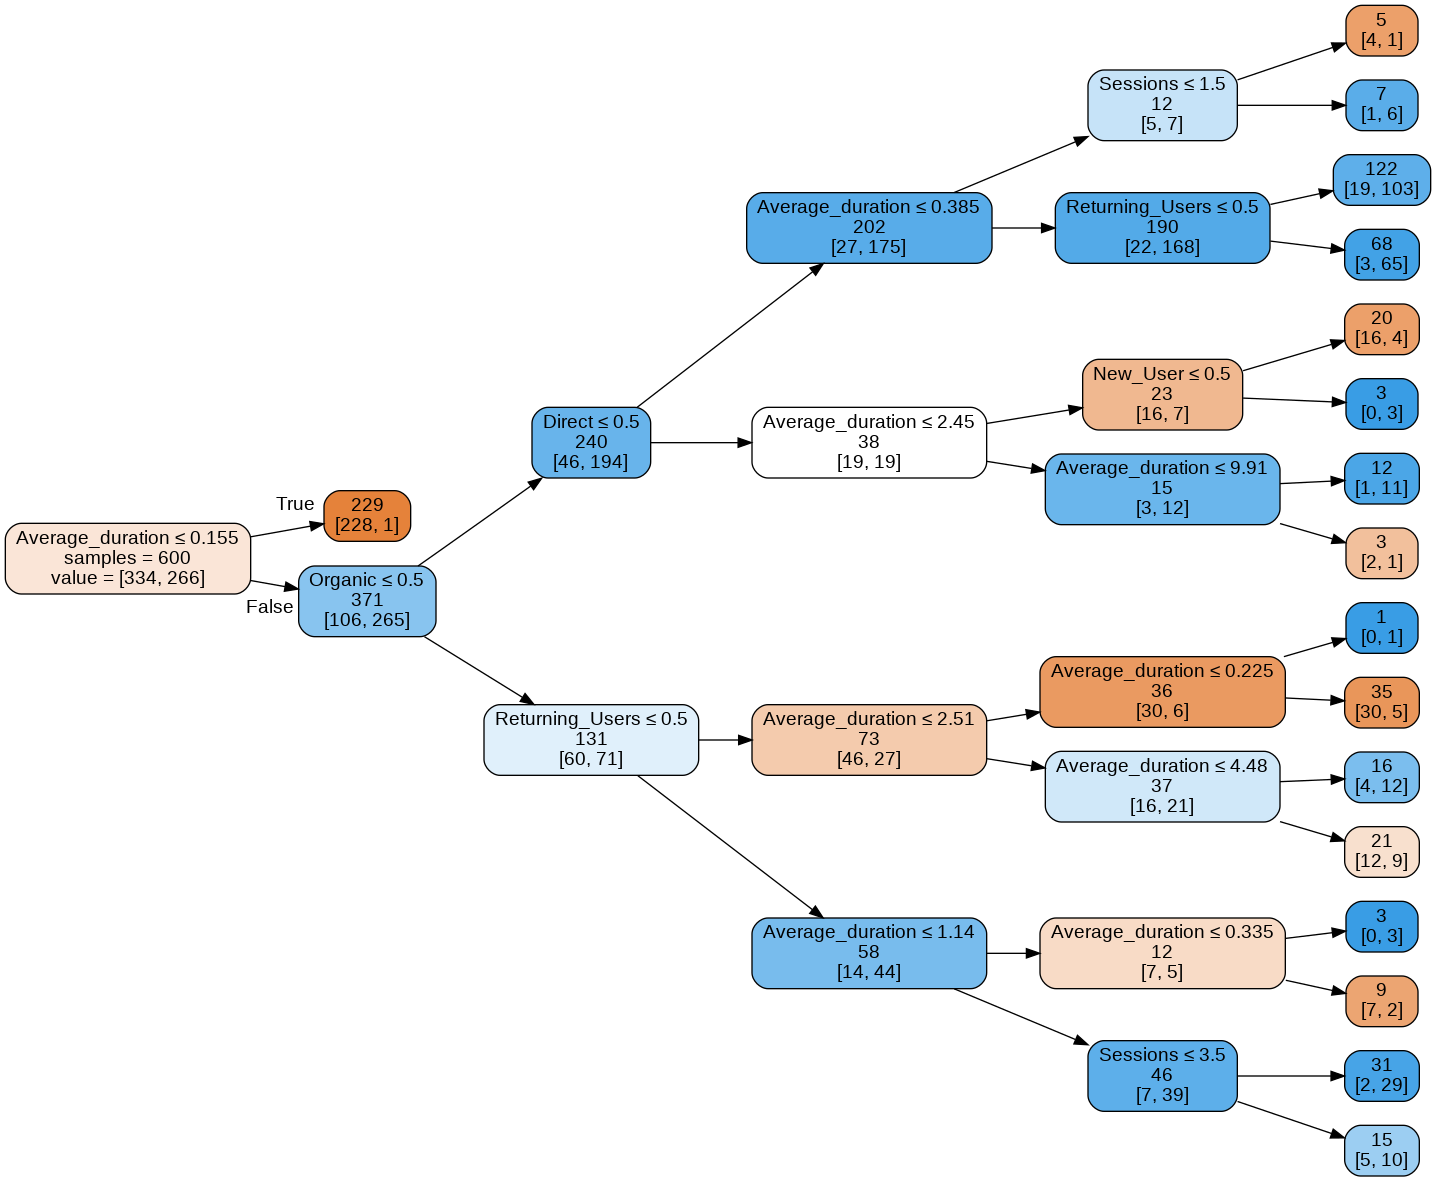

In [142]:
plotDecisionTree(bestClassTree2, feature_names=train_X_Tree2.columns,rotate=True)

In [100]:
# Setting roc metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
y_pred_proba_tree = bestClassTree2.predict_proba(valid_X_Tree2)[::,1]
y_pred_proba_log = logit_reg2.predict_proba(valid_X2)[::,1]
y_pred_proba_neural = clf.predict_proba(valid_X_5)[::,1]
y_pred_proba_rf = rfModelOS.predict_proba(valid_X_7)[::,1]
y_pred_proba_bagging = bagging.predict_proba(valid_X_8)[::,1]
y_pred_proba_boost = boost.predict_proba(valid_X_8)[::,1]
y_pred_proba_Gboost = gradientBoost.predict_proba(valid_X_8)[::,1]

fpr_tree, tpr_tree, _ = roc_curve(valid_y_Tree2, y_pred_proba_tree)
fpr_log, tpr_log, _ = roc_curve(valid_y2, y_pred_proba_log)
fpr_neural, tpr_neural, _ = roc_curve(valid_y_5, y_pred_proba_neural)
fpr_rf, tpr_rf, _ = roc_curve(valid_y_7, y_pred_proba_rf)
fpr_bagging, tpr_bagging, _ = roc_curve(valid_y_8, y_pred_proba_bagging)
fpr_boost, tpr_boost, _ = roc_curve(valid_y_8, y_pred_proba_boost)
fpr_Gboost, tpr_Gboost, _ = roc_curve(valid_y_8, y_pred_proba_Gboost)

roc_auc_tree = auc(fpr_tree, tpr_tree)
roc_auc_log = auc(fpr_log, tpr_log)
roc_auc_neural = auc(fpr_neural, tpr_neural)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_bagging = auc(fpr_bagging, tpr_bagging)
roc_auc_boost = auc(fpr_boost, tpr_boost)
roc_auc_Gboost = auc(fpr_Gboost, tpr_Gboost)

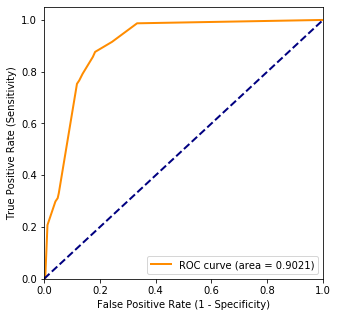

In [46]:
plt.figure(figsize=[5, 5])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")

plt.show()

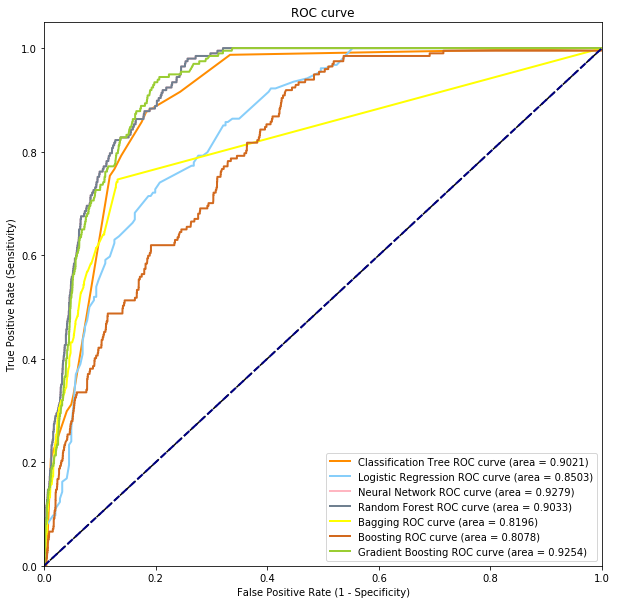

In [102]:
# ROC curve
plt.figure(figsize=[10, 10])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_tree, tpr_tree,color='darkorange',
         lw=lw, label='Classification Tree ROC curve (area = %0.4f)' % roc_auc_tree)
plt.plot(fpr_log, tpr_log,color='lightskyblue',
         lw=lw, label='Logistic Regression ROC curve (area = %0.4f)' % roc_auc_log)
plt.plot(fpr_neural, tpr_neural,color='lightpink',
         lw=lw, label='Neural Network ROC curve (area = %0.4f)' % roc_auc_neural)
plt.plot(fpr_neural, tpr_neural,color='slategray',
         lw=lw, label='Random Forest ROC curve (area = %0.4f)' % roc_auc_rf)
plt.plot(fpr_bagging, tpr_bagging,color='yellow',
         lw=lw, label='Bagging ROC curve (area = %0.4f)' % roc_auc_bagging)
plt.plot(fpr_boost, tpr_boost,color='chocolate',
         lw=lw, label='Boosting ROC curve (area = %0.4f)' % roc_auc_boost)
plt.plot(fpr_Gboost, tpr_Gboost,color='yellowgreen',
         lw=lw, label='Gradient Boosting ROC curve (area = %0.4f)' % roc_auc_Gboost)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [61]:
#Neural Network
from sklearn.neural_network import MLPClassifier
neural_df = oak_df.copy()
neural_df['Goal']= [0 if value == 0 else 1 for value in neural_df['Goal_Conversion_Rate']]
neural_df = neural_df.drop(columns=['Goal_Conversion_Rate'])
neural_df.shape



(23489, 17)

In [74]:
#Model
X_neural = neural_df.drop(columns=['Goal','Client_Id'])
y_neural = neural_df['Goal']
train_X_5, valid_X_5, train_y_5, valid_y_5 = train_test_split(X_neural, y_neural, test_size=0.4, random_state=1)
# train neural network with 2 hidden nodes
clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic',
solver='lbfgs',
random_state=1,max_iter = 200 )
clf.fit(train_X_5, train_y_5.values)
# training performance (use idxmax to revert the one-hot-encoding)
classificationSummary(train_y_5, clf.predict(train_X_5))
# validation performance
classificationSummary(valid_y_5, clf.predict(valid_X_5))

Confusion Matrix (Accuracy 0.9810)

       Prediction
Actual     0     1
     0 13825     1
     1   267     0
Confusion Matrix (Accuracy 0.9789)

       Prediction
Actual    0    1
     0 9197    2
     1  196    1


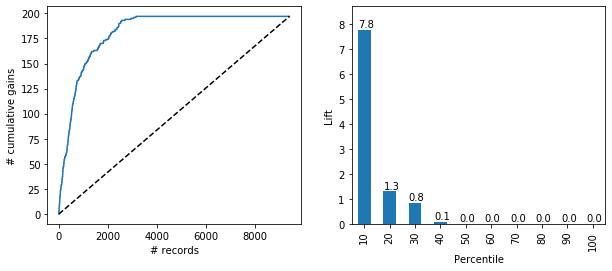

In [64]:
# Gain Chart
neural_pred = clf.predict(valid_X_5)
neural_proba = clf.predict_proba(valid_X_5)
neural_result = pd.DataFrame({'actual': valid_y_5,
  'p(0)': [p[0] for p in neural_proba],
  'p(1)': [p[1] for p in neural_proba],
  'predicted': neural_pred })
dfn = neural_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(dfn .actual, ax=axes[0])
liftChart(dfn ['p(1)'], title=False, ax=axes[1])
plt.show()

In [76]:
# Random Forest 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
rf_df = oak_df.copy()
rf_df['Goal']= [0 if value == 0 else 1 for value in rf_df['Goal_Conversion_Rate']]
rf_df = rf_df.drop(columns=['Goal_Conversion_Rate'])
rf_df.shape

(23489, 17)

In [78]:
X_rf = rf_df.drop(columns=['Goal','Client_Id'])
y_rf = rf_df['Goal']
train_X_6, valid_X_6, train_y_6, valid_y_6 = train_test_split(X_rf, y_rf, test_size=0.4, random_state=1)

rfModel = RandomForestClassifier(n_estimators=100, random_state=1)
rfModel.fit(train_X_6, train_y_6)

# training performance (use idxmax to revert the one-hot-encoding)
classificationSummary(train_y_6, rfModel.predict(train_X_6))
# validation performance
classificationSummary(valid_y_6, rfModel.predict(valid_X_6))

Confusion Matrix (Accuracy 0.9970)

       Prediction
Actual     0     1
     0 13823     3
     1    39   228
Confusion Matrix (Accuracy 0.9714)

       Prediction
Actual    0    1
     0 9102   97
     1  172   25


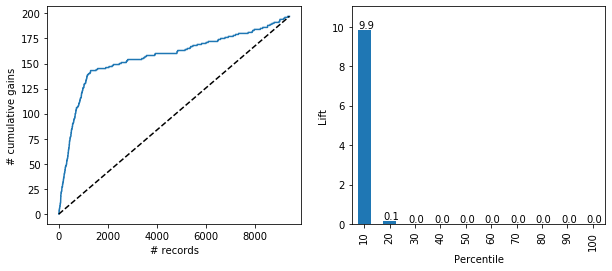

In [80]:
# Gain Chart
rf_pred = rfModel.predict(valid_X_6)
rf_proba = rfModel.predict_proba(valid_X_6)
rf_result = pd.DataFrame({'actual': valid_y_6,
  'p(0)': [p[0] for p in rf_proba],
  'p(1)': [p[1] for p in rf_proba],
  'predicted': rf_pred })
dfrf = rf_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(dfrf .actual, ax=axes[0])
liftChart(dfrf ['p(1)'], title=False, ax=axes[1])
plt.show()

In [81]:
# Random Forest oversample
weights = [0.9 if g == 1 else 0.01 for g in rf_df.Goal]
over_rf_df = rf_df.sample(1000, weights=weights,random_state=1)
over_rf_df['Goal'].value_counts()

0    580
1    420
Name: Goal, dtype: int64

In [83]:
X_rf_oversample = over_rf_df.drop(columns=['Goal','Client_Id'])
y_rf_oversample = over_rf_df['Goal']
train_X_7, valid_X_7, train_y_7, valid_y_7 = train_test_split(X_rf_oversample, y_rf_oversample, test_size=0.4, random_state=1)

rfModelOS = RandomForestClassifier(n_estimators=100, random_state=1)
rfModelOS.fit(train_X_7, train_y_7)

# training performance (use idxmax to revert the one-hot-encoding)
classificationSummary(train_y_7, rfModelOS.predict(train_X_7))
# validation performance
classificationSummary(valid_y_7, rfModelOS.predict(valid_X_7))

Confusion Matrix (Accuracy 0.9967)

       Prediction
Actual   0   1
     0 333   1
     1   1 265
Confusion Matrix (Accuracy 0.8200)

       Prediction
Actual   0   1
     0 206  40
     1  32 122


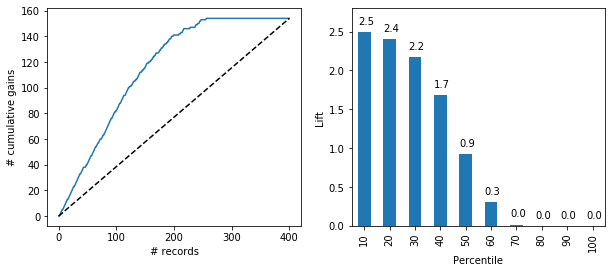

In [85]:
rf_oversample_pred = rfModelOS.predict(valid_X_7)
rf_oversample_proba = rfModelOS.predict_proba(valid_X_7)
rf_oversample_result = pd.DataFrame({'actual': valid_y_7,
  'p(0)': [p[0] for p in rf_oversample_proba],
  'p(1)': [p[1] for p in rf_oversample_proba],
  'predicted': rf_oversample_pred })
dfrf_os = rf_oversample_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(dfrf_os .actual, ax=axes[0])
liftChart(dfrf_os ['p(1)'], title=False, ax=axes[1])
plt.show()

In [88]:
# Bagging and Boosting Classification Trees
bb_df = oak_df.copy()
bb_df['Goal']= [0 if value == 0 else 1 for value in bb_df['Goal_Conversion_Rate']]
bb_df = bb_df.drop(columns=['Goal_Conversion_Rate'])
bb_df.shape

(23489, 17)

In [91]:
X_bb = bb_df.drop(columns=['Goal','Client_Id'])
y_bb = bb_df['Goal']
train_X_8, valid_X_8, train_y_8, valid_y_8 = train_test_split(X_bb, y_bb, test_size=0.4, random_state=1)
# bagging
bagging = BaggingClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
bagging.fit(train_X_8, train_y_8)
# training performance (use idxmax to revert the one-hot-encoding)
classificationSummary(train_y_8, bagging.predict(train_X_8))
# validation performance
classificationSummary(valid_y_8, bagging.predict(valid_X_8))

Confusion Matrix (Accuracy 0.9970)

       Prediction
Actual     0     1
     0 13823     3
     1    39   228
Confusion Matrix (Accuracy 0.9744)

       Prediction
Actual    0    1
     0 9131   68
     1  173   24


In [92]:
# boosting
boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=1),n_estimators=100, random_state=1)
boost.fit(train_X_8, train_y_8)

# training performance (use idxmax to revert the one-hot-encoding)
classificationSummary(train_y_8, boost.predict(train_X_8))
# validation performance
classificationSummary(valid_y_8, boost.predict(valid_X_8))

Confusion Matrix (Accuracy 0.9971)

       Prediction
Actual     0     1
     0 13817     9
     1    32   235
Confusion Matrix (Accuracy 0.9701)

       Prediction
Actual    0    1
     0 9102   97
     1  184   13


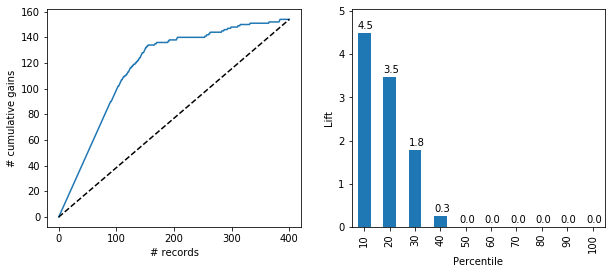

In [93]:
# Bagging Gain chart
bagging_pred = bagging.predict(valid_X_7)
bagging_proba = bagging.predict_proba(valid_X_7)
bagging_result = pd.DataFrame({'actual': valid_y_7,
  'p(0)': [p[0] for p in bagging_proba],
  'p(1)': [p[1] for p in bagging_proba],
  'predicted': bagging_pred })
df_bagging = bagging_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df_bagging .actual, ax=axes[0])
liftChart(df_bagging ['p(1)'], title=False, ax=axes[1])
plt.show()

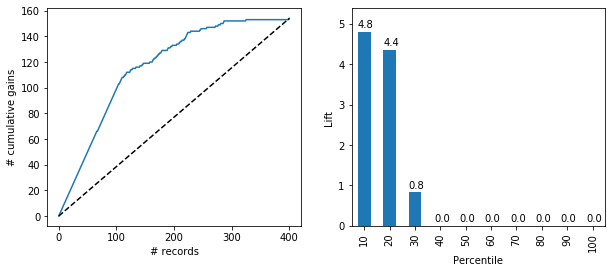

In [94]:
# boost Gain chart
boost_pred = boost.predict(valid_X_7)
boost_proba = boost.predict_proba(valid_X_7)
boost_result = pd.DataFrame({'actual': valid_y_7,
  'p(0)': [p[0] for p in boost_proba],
  'p(1)': [p[1] for p in boost_proba],
  'predicted': boost_pred })
df_boost = boost_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df_boost .actual, ax=axes[0])
liftChart(df_boost ['p(1)'], title=False, ax=axes[1])
plt.show()

In [98]:
gradientBoost = GradientBoostingClassifier()
gradientBoost.fit(train_X_8, train_y_8)

# training performance (use idxmax to revert the one-hot-encoding)
classificationSummary(train_y_8, gradientBoost.predict(train_X_8))
# validation performance
classificationSummary(valid_y_8, gradientBoost.predict(valid_X_8))

Confusion Matrix (Accuracy 0.9829)

       Prediction
Actual     0     1
     0 13823     3
     1   238    29
Confusion Matrix (Accuracy 0.9783)

       Prediction
Actual    0    1
     0 9190    9
     1  195    2


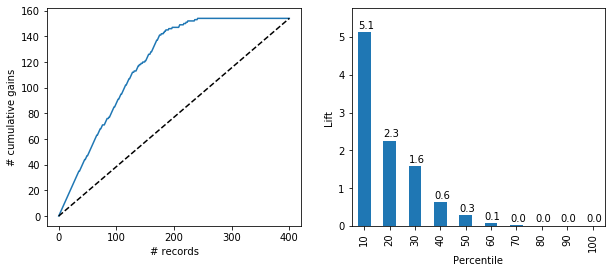

In [99]:
gradientBoost_pred = gradientBoost.predict(valid_X_7)
gradientBoost_proba = gradientBoost.predict_proba(valid_X_7)
gradientBoost_result = pd.DataFrame({'actual': valid_y_7,
  'p(0)': [p[0] for p in gradientBoost_proba],
  'p(1)': [p[1] for p in gradientBoost_proba],
  'predicted': gradientBoost_pred })
df_gradientBoost = gradientBoost_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df_gradientBoost .actual, ax=axes[0])
liftChart(df_gradientBoost ['p(1)'], title=False, ax=axes[1])
plt.show()